## Parte 3 

### Análisis de componentes no analizados

#### Generacion de archivos con datos no procesados

Se extraen los textos que no han sido procesados:

In [3]:
import pandas as pd
import numpy as np
dfNegativeNo = pd.read_json('dfNegative.json')
dfNegativeNo = dfNegativeNo.dropna()
dfNegativeNo = dfNegativeNo[~dfNegativeNo['tree'].str.contains("Root").fillna(False)]
dfNegativeNo['tree'] =  np.nan
dfNegativeNo.to_json(r'dfNegativeNo.json')

In [4]:
dfPositiveNo = pd.read_json('dfPositive.json')
dfPositiveNo = dfPositiveNo.dropna()
dfPositiveNo = dfPositiveNo[~dfPositiveNo['tree'].str.contains("Root").fillna(False)]
dfPositiveNo['tree'] =  np.nan
dfPositiveNo.to_json(r'dfPositiveNo.json')

#### Análisis de componentes

Se hacen los analisis de los componentes que no se procesaron (alrededor de un 50% de los casos):

In [17]:
import os
import docker
import math
import signal
import multiprocessing
import time
import pickle5 as pickle
import numpy as np

client = docker.from_env()
from IPython.display import clear_output


class TimeoutException(Exception): 
    pass

def timeout_handler(signum, frame): 
    raise TimeoutException

signal.signal(signal.SIGALRM, timeout_handler)

def coherence(row):

    if((pd.isna(row["tree"]))):
        os.system("echo '"+row['text']+"' > input.txt")
        os.system("cp input.txt /Users/raulbarrantes/tmp/")
        clear_output(wait=True)
        print(row.name)
        signal.alarm(360)
        try:
            return client.containers.run("nlpbox/codra", "/tmp/input.txt",  tty=True, volumes={'/Users/raulbarrantes/tmp': {'bind': '/tmp/'}},)
        except TimeoutException: 
            return "Timeout"
        except:
            return "Error del formato de archivo"
    else:
        return row["tree"]
    


In [ ]:
for n in range(0, 5000, 50):
    dfNegativeNo['tree'] = dfNegativeNo.iloc[0:n+1].apply(coherence,axis=1)
    dfNegativeNo.to_json(r'dfNegativeNo.json')

In [ ]:
for n in range(0, 5000, 50):
    dfPositiveNo['tree'] = dfPositiveNo.iloc[0:n+1].apply(coherence,axis=1)
    dfPositiveNo.to_json(r'dfPositiveNo.json')

In [5]:
dfNegativeNo = pd.read_json('dfNegativeNo.json')

In [6]:
dfPositiveNo = pd.read_json('dfPositiveNo.json')

### Análisis de patrones en los textos

In [75]:
import pandas as pd
dfNegative = pd.read_json('dfNegative.json')
dfPositive = pd.read_json('dfPositive.json')
dfPositive = dfPositive.dropna()
dfPositive = dfPositive[dfPositive['tree']!='No']
dfPositive = dfPositive[dfPositive['tree'].str.contains("Root").fillna(False)]
dfNegative = dfNegative.dropna()
dfNegative = dfNegative[dfNegative['tree']!='No']
dfNegative = dfNegative[dfNegative['tree'].str.contains("Root").fillna(False)]

In [76]:
dfNegative = dfNegative.reset_index(drop=True)
dfPositive = dfPositive.reset_index(drop=True)

Se guardan los textos en una archivo json.

In [77]:
dfNegative.to_json(r'dfNegativeSi.json')
dfPositive.to_json(r'dfPositiveSi.json')

### Extracción de estructura de los textos

Se extraen los textos mediante regex:

In [78]:
import re
a = re.sub(r"\( (Nucleus).*\) \)", "(\1)", dfPositive['tree'].iloc[18000])
b = re.sub(r"\( (Satellite).*\) \)", "(Satellite)",a)
c = re.sub(r"\( (Nucleus) .*\)", "(Nucleus", b)
d = re.sub(r"\( (Satellite) .*\)", "(Satellite",c)
e = re.sub(r"\( (Satellite) .*\)", "(Satellite",d)
f = re.sub(r"\( Root .*\n", "",e)
g = re.sub(r"\n", "",f)
h = re.sub(r" ", "",g)
i = re.sub(r"\r", "",h)
j = re.sub(r"\)$", "",i)
j

'(Nucleus(\x01)(Satellite(Nucleus(\x01)(Satellite))(Nucleus(\x01)(\x01))))(Satellite)'

In [79]:
import re
def get_structure(sentence):
    a = re.sub(r"\( (Nucleus).*\) \)", "(Nucleus)", sentence)
    b = re.sub(r"\( (Satellite).*\) \)", "(Satellite)",a)
    c = re.sub(r"\( (Nucleus) .*\)", "(Nucleus", b)
    d = re.sub(r"\( (Satellite) .*\)", "(Satellite",c)
    e = re.sub(r"\( (Satellite) .*\)", "(Satellite",d)
    f = re.sub(r"\( Root .*\n", "",e)
    g = re.sub(r"\n", "",f)
    h = re.sub(r" ", "",g)
    i = re.sub(r"\r", "",h)
    j = re.sub(r"\)$", "",i)
    return j

In [80]:
dfPositive['structure'] = dfPositive['tree'].apply(lambda x: get_structure(x))
dfNegative['structure'] = dfNegative['tree'].apply(lambda x: get_structure(x))

Aquí se muestran las estructuras más comunes del corpus positivo:

In [81]:
dfPositive['structure'].value_counts()[:10]

(Nucleus)(Satellite)                        1798
(Satellite)(Nucleus)                         805
(Nucleus)(Satellite(Nucleus)(Satellite))     519
(Nucleus)(Nucleus)                           437
(Nucleus(Nucleus)(Satellite))(Satellite)     430
(Nucleus)(Satellite(Satellite)(Nucleus))     259
(Satellite)(Nucleus(Nucleus)(Satellite))     257
(Nucleus(Nucleus)(Satellite))(Nucleus)       245
(Nucleus)(Nucleus(Nucleus)(Satellite))       235
(Nucleus)(Satellite(Nucleus)(Nucleus))       206
Name: structure, dtype: int64

Aquí se muestran las estructuras más comunes del corpus negativo:

In [82]:
dfNegative['structure'].value_counts()[:10]

(Nucleus)(Satellite)                        5069
(Satellite)(Nucleus)                        1440
(Nucleus)(Satellite(Nucleus)(Satellite))    1116
(Nucleus)(Nucleus)                           710
(Nucleus(Nucleus)(Satellite))(Satellite)     633
(Nucleus(Nucleus)(Satellite))(Nucleus)       590
(Nucleus)(Satellite(Satellite)(Nucleus))     424
(Satellite)(Nucleus(Nucleus)(Satellite))     405
(Nucleus)(Nucleus(Nucleus)(Satellite))       370
(Nucleus(Satellite)(Nucleus))(Satellite)     314
Name: structure, dtype: int64

### Porcentajes

#### Corpus Positivo

In [83]:
s = dfPositive.structure
counts = s.value_counts()
percent = s.value_counts(normalize=True)
percent100 = s.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
pd.DataFrame({'counts': counts, 'per': percent, 'per100': percent100}).head(10)

,counts,per,per100
(Nucleus)(Satellite),1798,0.098634,9.9%
(Satellite)(Nucleus),805,0.044160,4.4%
(Nucleus)(Satellite(Nucleus)(Satellite)),519,0.028471,2.8%
(Nucleus)(Nucleus),437,0.023973,2.4%
(Nucleus(Nucleus)(Satellite))(Satellite),430,0.023589,2.4%
(Nucleus)(Satellite(Satellite)(Nucleus)),259,0.014208,1.4%
(Satellite)(Nucleus(Nucleus)(Satellite)),257,0.014098,1.4%
(Nucleus(Nucleus)(Satellite))(Nucleus),245,0.013440,1.3%
(Nucleus)(Nucleus(Nucleus)(Satellite)),235,0.012892,1.3%
(Nucleus)(Satellite(Nucleus)(Nucleus)),206,0.011301,1.1%


#### Corpus Negativo

In [84]:
s = dfNegative.structure
counts = s.value_counts()
percent = s.value_counts(normalize=True)
percent100 = s.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
pd.DataFrame({'counts': counts, 'per': percent, 'per100': percent100}).head(10)

,counts,per,per100
(Nucleus)(Satellite),5069,0.189163,18.9%
(Satellite)(Nucleus),1440,0.053737,5.4%
(Nucleus)(Satellite(Nucleus)(Satellite)),1116,0.041646,4.2%
(Nucleus)(Nucleus),710,0.026496,2.6%
(Nucleus(Nucleus)(Satellite))(Satellite),633,0.023622,2.4%
(Nucleus(Nucleus)(Satellite))(Nucleus),590,0.022017,2.2%
(Nucleus)(Satellite(Satellite)(Nucleus)),424,0.015823,1.6%
(Satellite)(Nucleus(Nucleus)(Satellite)),405,0.015114,1.5%
(Nucleus)(Nucleus(Nucleus)(Satellite)),370,0.013808,1.4%
(Nucleus(Satellite)(Nucleus))(Satellite),314,0.011718,1.2%


In [86]:
s = dfPositive.structure
counts = s.value_counts()
percent = s.value_counts(normalize=True)
percent100 = s.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
pd.DataFrame({'counts': counts, 'per': percent, 'per100': percent100}).head(10)

,counts,per,per100
(Nucleus)(Satellite),1798,0.098634,9.9%
(Satellite)(Nucleus),805,0.044160,4.4%
(Nucleus)(Satellite(Nucleus)(Satellite)),519,0.028471,2.8%
(Nucleus)(Nucleus),437,0.023973,2.4%
(Nucleus(Nucleus)(Satellite))(Satellite),430,0.023589,2.4%
(Nucleus)(Satellite(Satellite)(Nucleus)),259,0.014208,1.4%
(Satellite)(Nucleus(Nucleus)(Satellite)),257,0.014098,1.4%
(Nucleus(Nucleus)(Satellite))(Nucleus),245,0.013440,1.3%
(Nucleus)(Nucleus(Nucleus)(Satellite)),235,0.012892,1.3%
(Nucleus)(Satellite(Nucleus)(Nucleus)),206,0.011301,1.1%


### Análisis de tipos de patrones*

Los patrones se categorizan entre diferentes tipos, siendo 1 el patrón más sencillo, así se incremente hasta patrones más complejos.

In [119]:
def get_structureType(sentence):
    return (sentence.count('(') + sentence.count(')'))/4

In [120]:
dfPositive['structureType'] = dfPositive['structure'].apply(lambda x: get_structureType(x))
dfNegative['structureType'] = dfNegative['structure'].apply(lambda x: get_structureType(x))

<BarContainer object of 5 artists>

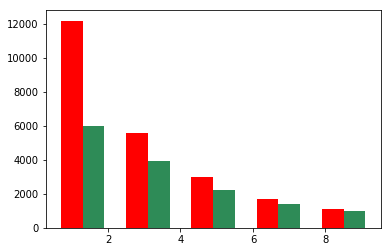

In [121]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()

a_heights, a_bins = np.histogram(dfNegative['structureType'], bins=5, range=(1,10))
b_heights, b_bins = np.histogram(dfPositive['structureType'], bins=5, range=(1,10))

width = (a_bins[1] - a_bins[0])/3

ax.bar(a_bins[:-1], a_heights, width=width, facecolor='red')
ax.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='seagreen')

In [122]:
dfPositive.loc[dfPositive['structureType'] > 10, 'structureType'] = "> 10"
dfNegative.loc[dfNegative['structureType'] > 10, 'structureType'] = "> 10"

In [123]:
dfPositive['structureType'].value_counts()

> 10    3664
1.0     3041
2.0     2964
3.0     2330
4.0     1606
5.0     1280
6.0      973
7.0      756
8.0      637
9.0      512
10.0     466
Name: structureType, dtype: int64

In [124]:
dfNegative['structureType'].value_counts()[:10]

1.0     7219
2.0     4983
3.0     3309
> 10    3202
4.0     2285
5.0     1742
6.0     1246
7.0      951
8.0      737
9.0      596
Name: structureType, dtype: int64

#### Porcentajes

##### Corpus Positivo

In [125]:
s = dfPositive.structureType
counts = s.value_counts()
percent = s.value_counts(normalize=True)
percent100 = s.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
pd.DataFrame({'counts': counts, 'per': percent, 'per100': percent100}).head(10)

,counts,per,per100
> 10,3664,0.200998,20.1%
1.0,3041,0.166822,16.7%
2.0,2964,0.162598,16.3%
3.0,2330,0.127818,12.8%
4.0,1606,0.088101,8.8%
5.0,1280,0.070218,7.0%
6.0,973,0.053376,5.3%
7.0,756,0.041472,4.1%
8.0,637,0.034944,3.5%
9.0,512,0.028087,2.8%


##### Corpus Negativo

In [126]:
s = dfNegative.structureType
counts = s.value_counts()
percent = s.value_counts(normalize=True)
percent100 = s.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
pd.DataFrame({'counts': counts, 'per': percent, 'per100': percent100}).head(10)

,counts,per,per100
1.0,7219,0.269396,26.9%
2.0,4983,0.185954,18.6%
3.0,3309,0.123484,12.3%
> 10,3202,0.119491,11.9%
4.0,2285,0.085271,8.5%
5.0,1742,0.065007,6.5%
6.0,1246,0.046498,4.6%
7.0,951,0.035489,3.5%
8.0,737,0.027503,2.8%
9.0,596,0.022241,2.2%


### Cálculo de la profundidad de los textos*

Se calcula la profundidad de las oraciones y sentencias.

In [136]:
def deepness(str_):
    count = 0
    a = 0
    for c in str_:
        if (c == ')'):
            count += 1
        else:
            if (count > a):
                a = count
            count = 0
    if (count > a):
        a = count
    return a

In [137]:
dfPositive['deepness'] = dfPositive['structure'].apply(lambda x: deepness(x))
dfNegative['deepness'] = dfNegative['structure'].apply(lambda x: deepness(x))

<BarContainer object of 5 artists>

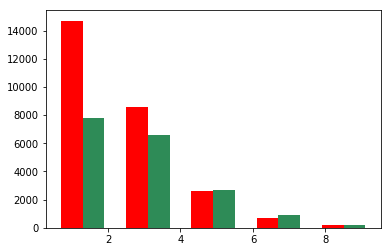

In [138]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()

a_heights, a_bins = np.histogram(dfNegative['deepness'], bins=5, range=(1,10))
b_heights, b_bins = np.histogram(dfPositive['deepness'], bins=5, range=(1,10))

width = (a_bins[1] - a_bins[0])/3

ax.bar(a_bins[:-1], a_heights, width=width, facecolor='red')
ax.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='seagreen')

### Medias

In [139]:
dfPositive["deepness"].mean()

3.1986943880629766

In [140]:
dfNegative["deepness"].mean()

2.693697055640557

### Medianas

In [141]:
dfPositive["deepness"].median()

3.0

In [142]:
dfNegative["deepness"].median()

2.0

### Porcentajes

In [143]:
dfPositive.loc[dfPositive['deepness'] > 10, 'deepness'] = "> 10"
dfNegative.loc[dfNegative['deepness'] > 10, 'deepness'] = "> 10"

#### Corpus Positivo

In [144]:
s = dfPositive.deepness
counts = s.value_counts()
percent = s.value_counts(normalize=True)
percent100 = s.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
pd.DataFrame({'counts': counts, 'per': percent, 'per100': percent100}).head(20)

,counts,per,per100
2,4761,0.261177,26.1%
3,3983,0.218498,21.8%
1,3041,0.166822,16.7%
4,2629,0.144221,14.4%
5,1692,0.092819,9.3%
6,995,0.054583,5.5%
7,598,0.032805,3.3%
8,283,0.015525,1.6%
9,149,0.008174,0.8%
10,55,0.003017,0.3%


#### Corpus Negativo

In [145]:
s = dfNegative.deepness
counts = s.value_counts()
percent = s.value_counts(normalize=True)
percent100 = s.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
pd.DataFrame({'counts': counts, 'per': percent, 'per100': percent100}).head(10)

,counts,per,per100
2,7487,0.279397,27.9%
1,7219,0.269396,26.9%
3,5433,0.202747,20.3%
4,3142,0.117252,11.7%
5,1688,0.062992,6.3%
6,904,0.033735,3.4%
7,470,0.017539,1.8%
8,255,0.009516,1.0%
9,125,0.004665,0.5%
10,44,0.001642,0.2%
